In [5]:
import os, sys
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from scipy.constants import c as c_light

from wakis import SolverFIT3D
from wakis import GridFIT3D 
from wakis import WakeSolver

In [ ]:
conductivities = [10, 100, 1000, 1e4, 1e5, 1e6, 1e7, 1e8]

for cond in conductivities:
    print(f'Simulating with conductivity: {int(cond)}')
    print('-----------------------------------------')
    # ---------- Domain setup ---------
    # Number of mesh cells
    Nx = 60
    Ny = 60
    Nz = 150
    #dt = 5.707829241e-12 # CST

    # Embedded boundaries
    stl_cavity = 'cavity.stl' 
    stl_shell = 'shell.stl'
    surf = pv.read(stl_shell)
    
    stl_solids = {'cavity': stl_cavity, 'shell': stl_shell}
    stl_materials = {'cavity': 'vacuum', 'shell': [np.power(cond, 4/5), 1.0, np.power(cond,4/5)]}
    
    # Domain bounds
    xmin, xmax, ymin, ymax, zmin, zmax = surf.bounds
    Lx, Ly, Lz = (xmax-xmin), (ymax-ymin), (zmax-zmin)
    
    # set grid and geometry
    grid = GridFIT3D(xmin, xmax, ymin, ymax, zmin, zmax, Nx, Ny, Nz, 
                    stl_solids=stl_solids, 
                    stl_materials=stl_materials)
        
    # ------------ Beam source ----------------
    # Beam parameters
    sigmaz = 5e-2       #[m] -> 2 GHz
    q = 1e-9            #[C]
    beta = 1.0          # beam beta TODO
    xs = 0.             # x source position [m]
    ys = 0.             # y source position [m]
    xt = 0.             # x test position [m]
    yt = 0.             # y test position [m]
    # [DEFAULT] tinj = 8.53*sigmaz/c_light  # injection time offset [s] 
    
    # Simualtion
    wakelength = 100. #[m]
    add_space = 30   # no. cells

    results_folder = f'results_cond{int(cond)}_WL{int(wakelength)}_pow0.8/'
    wake = WakeSolver(q=q, sigmaz=sigmaz, beta=beta,
                xsource=xs, ysource=ys, xtest=xt, ytest=yt,
                add_space=add_space, results_folder=results_folder,
                Ez_file=results_folder+'Ez.h5')
    
    # ----------- Solver & Simulation ----------
    # boundary conditions``
    bc_low=['pec', 'pec', 'pec']
    bc_high=['pec', 'pec', 'pec']
    
    solver = SolverFIT3D(grid, wake,
                         bc_low=bc_low, bc_high=bc_high, 
                         use_stl=True, 
                         use_gpu=True,
                         bg='pec')
    
    # Run wakefield time-domain simulation
    solver.wakesolve(wakelength=wakelength)

Simulating with conductivity: 10
-----------------------------------------
Generating grid...
Importing STL solids...
Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Calculating maximal stable timestep...
Pre-computing...
Moving to GPU...
Total initialization time: 1.4583735466003418 s
Running electromagnetic time-domain simulation...


100%|██████████| 62211/62211 [04:04<00:00, 254.61it/s]


Reading h5 file results_cond10_WL100_pow0.8/Ez.h5
Calculating longitudinal wake potential WP(s)


100%|██████████| 555732/555732 [03:10<00:00, 2919.62it/s] 


Calculating transverse wake potential WPx, WPy...


100%|██████████| 555732/555732 [00:07<00:00, 79188.49it/s] 


Calculating longitudinal impedance Z...
Calculating transverse impedance Zx, Zy...
Simulating with conductivity: 100
-----------------------------------------
Generating grid...
Importing STL solids...
Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Calculating maximal stable timestep...
Pre-computing...
Moving to GPU...
Total initialization time: 0.9480571746826172 s
Running electromagnetic time-domain simulation...


  6%|▌         | 3779/62211 [00:13<03:32, 275.32it/s]

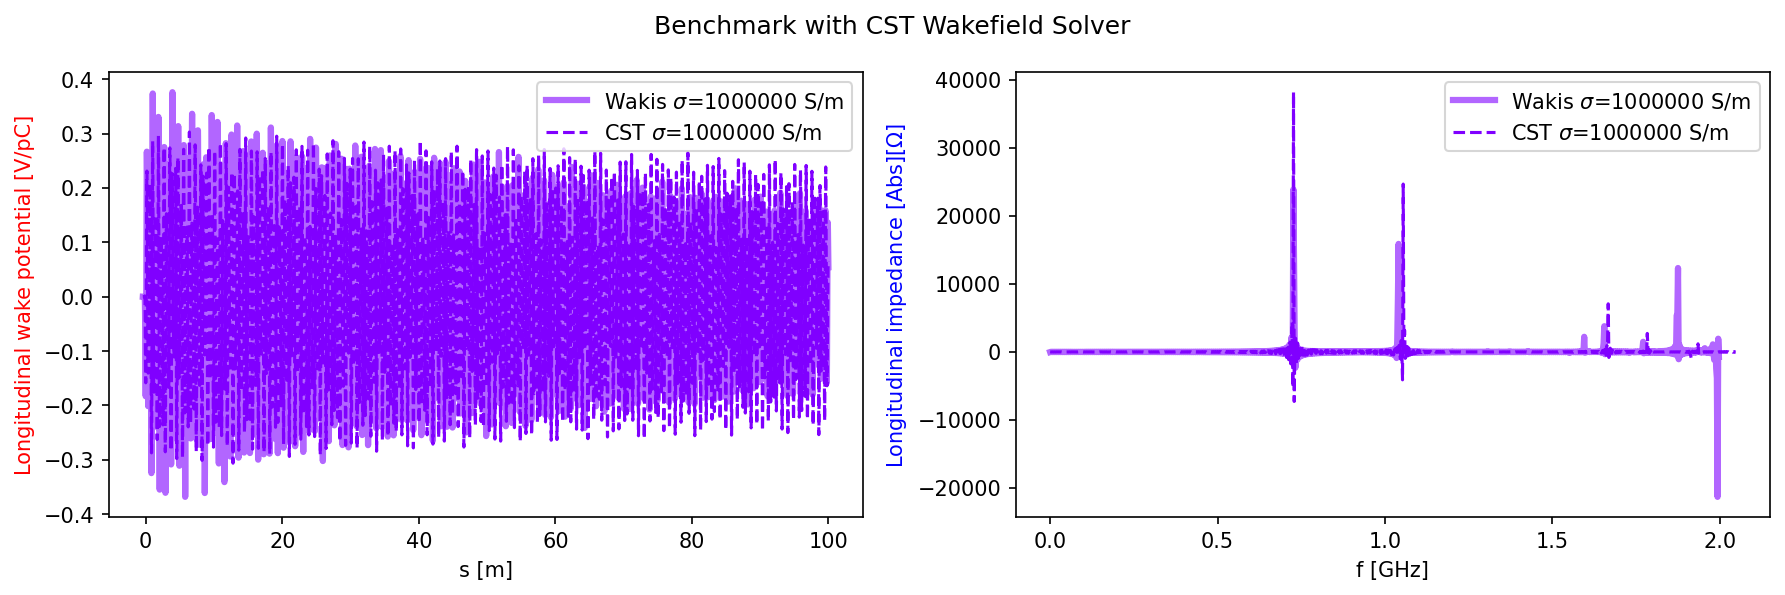

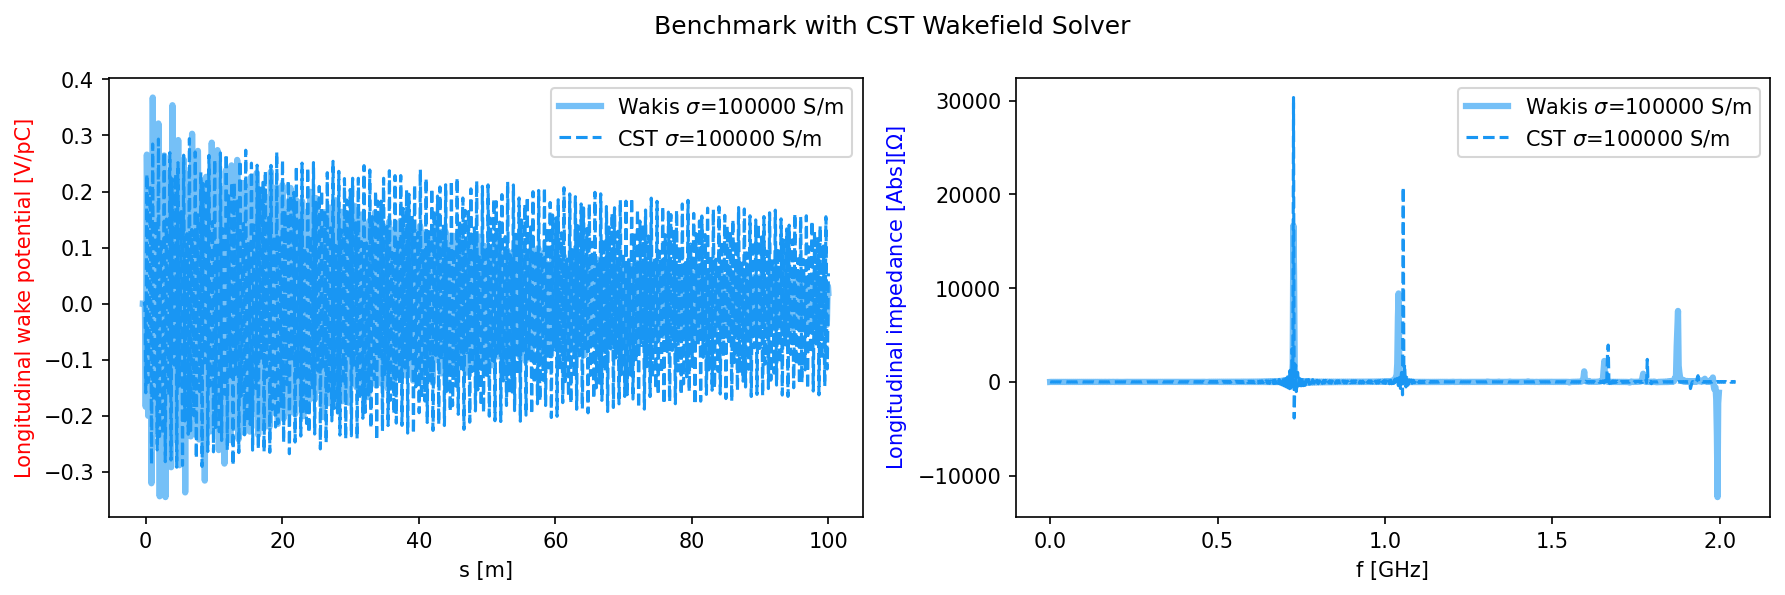

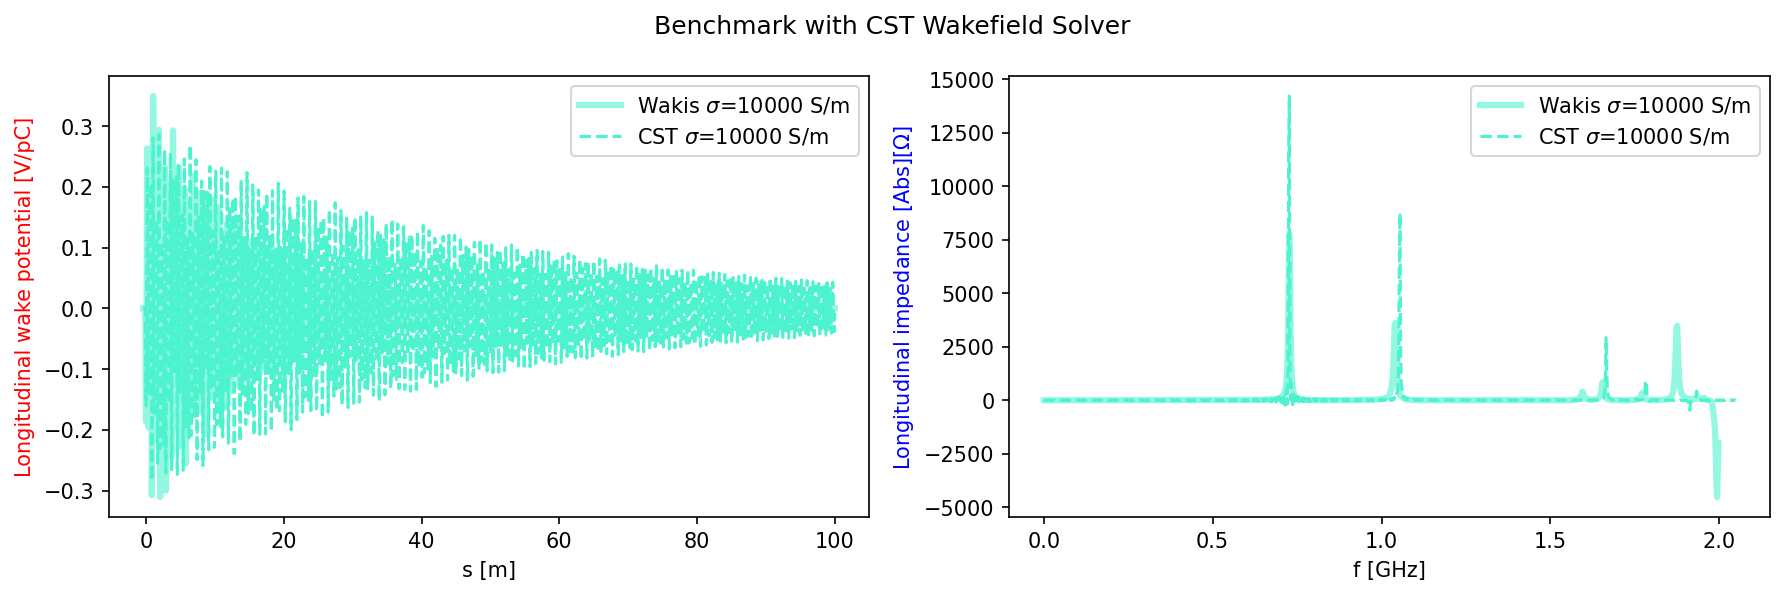

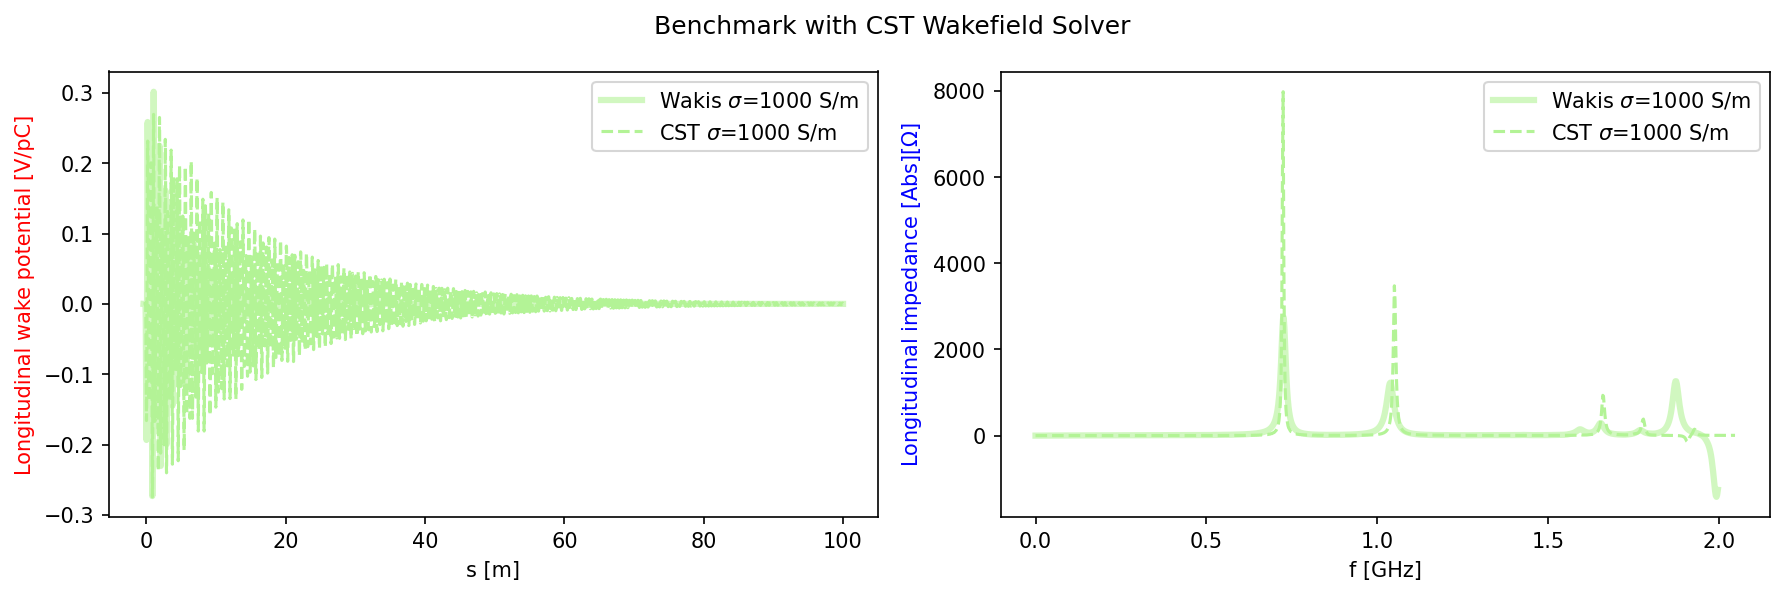

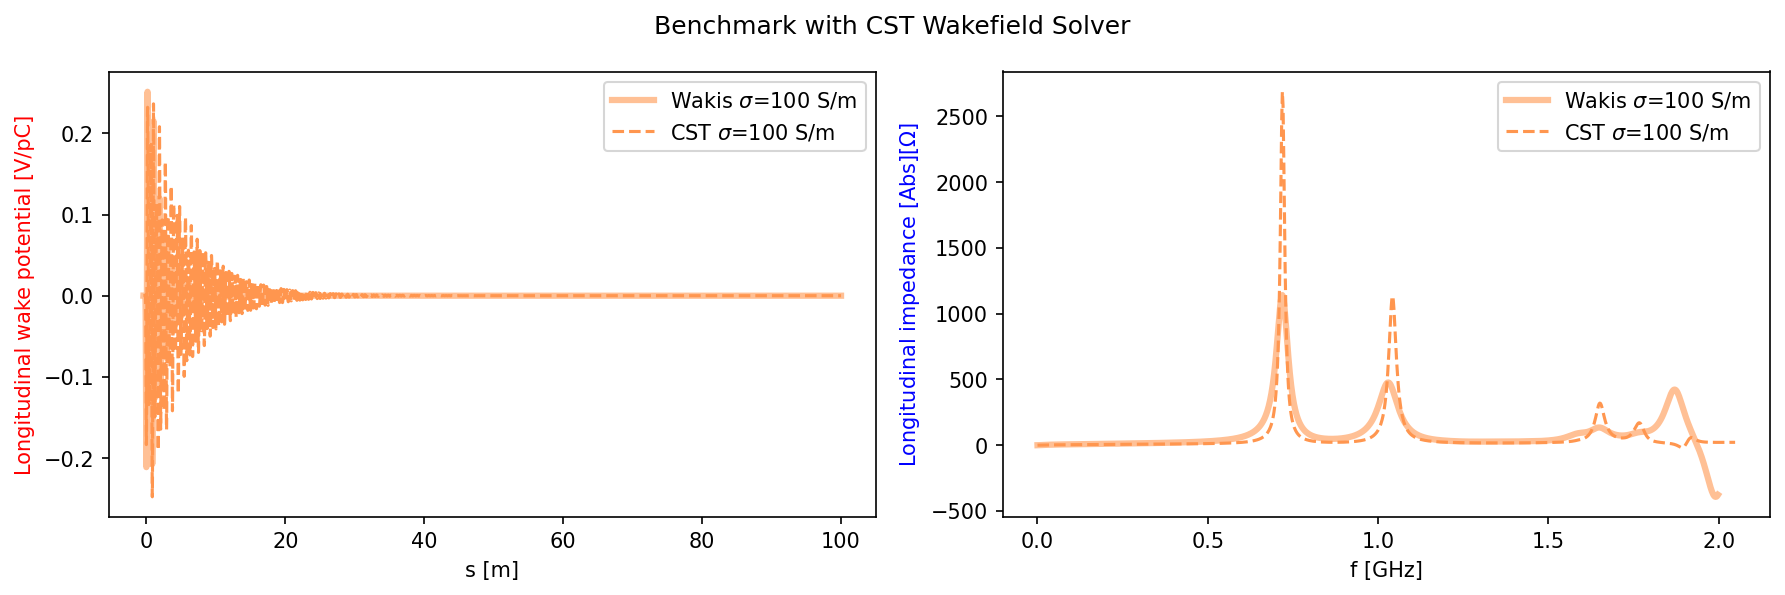

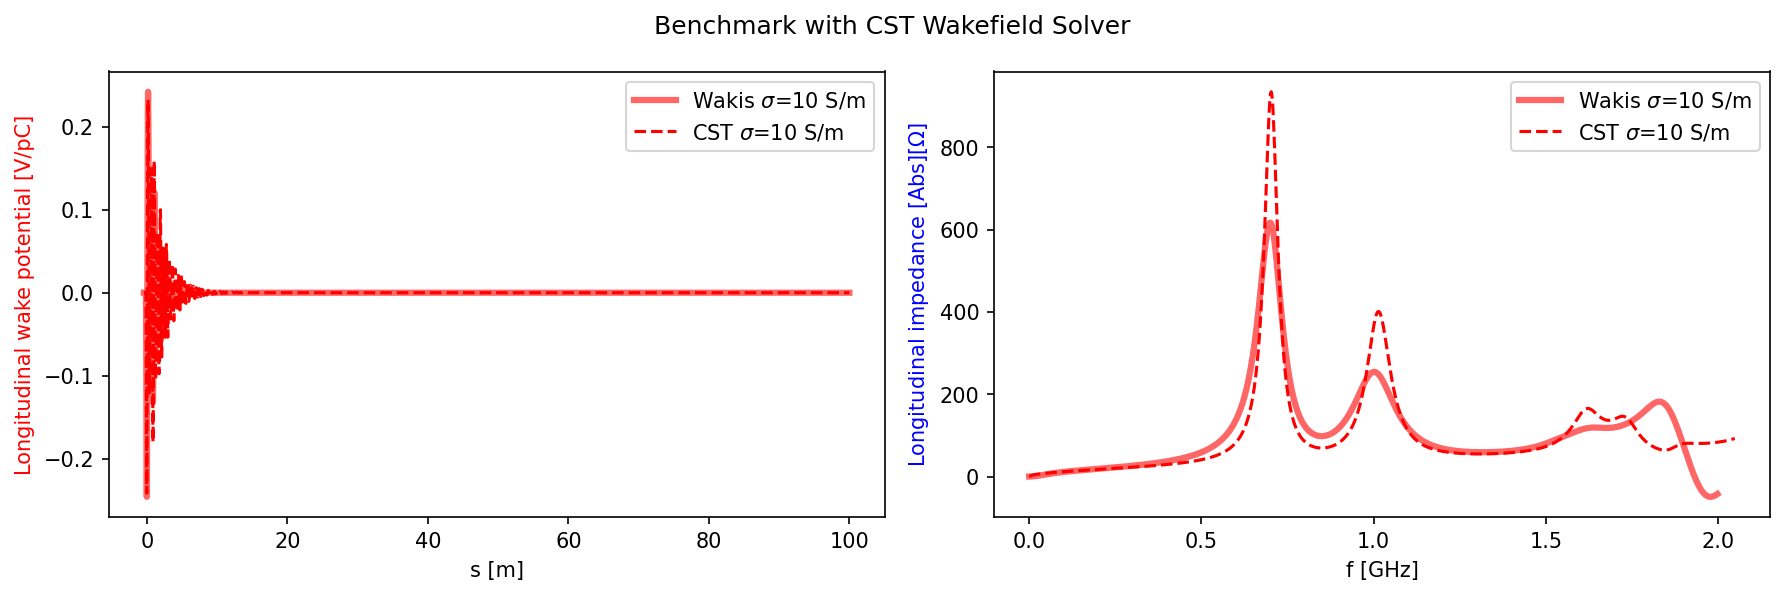

In [4]:
# Compare with CST
import matplotlib as mpl

wake = WakeSolver()
conds = [10, 100, 1000, 10000, 100000, 1000000]
res = {}
cstWP, cstZ = {}, {}
colors = mpl.colormaps['rainbow'](np.linspace(0., 1.0, len(conds)))
for k, cond in enumerate(reversed(conds)):
    fig, ax = plt.subplots(1,2, figsize=[12,4], dpi=150)
    res[k] = wake.copy()
    res[k].load_results(f'results_cond{cond}_WL100_sqrt/')
    cstWP[k] = wake.read_txt(f'cst/WP_sigma{cond}.txt')
    cstZ[k] = wake.read_txt(f'cst/Z_sigma{cond}.txt')

    ax[0].plot(res[k].s, res[k].WP, c=colors[k], lw=3, alpha=0.6, label=f'Wakis $\sigma$={cond} S/m')
    ax[0].plot(cstWP[k][0]*1e-2, cstWP[k][1], c=colors[k], ls='--', lw=1.5, label=f'CST $\sigma$={cond} S/m')

    ax[1].plot(res[k].f*1e-9, res[k].Z.real, c=colors[k], lw=3, alpha=0.6, label=f'Wakis $\sigma$={cond} S/m')
    ax[1].plot(cstZ[k][0], cstZ[k][1].real, c=colors[k], ls='--', lw=1.5, label=f'CST $\sigma$={cond} S/m')

    ax[0].set_xlabel('s [m]')
    ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='r')
    ax[0].legend()
    
    ax[1].set_xlabel('f [GHz]')
    ax[1].set_ylabel('Longitudinal impedance [Abs][$\Omega$]', color='b')
    ax[1].legend()
    
    fig.suptitle('Benchmark with CST Wakefield Solver')
    fig.tight_layout()
    fig.savefig(f'benchmark_cond{cond}.png')


In [ ]:
# Compare with Wakis
import matplotlib as mpl

wake = WakeSolver()
conds = [10, 100, 1000, 10000, 100000, 1000000]
res = {}
res2 = {}
colors = mpl.colormaps['rainbow'](np.linspace(0., 1.0, len(conds)))
for k, cond in enumerate(reversed(conds)):
    fig, ax = plt.subplots(1,2, figsize=[12,4], dpi=150)
    res[k] = wake.copy()
    res[k].load_results(f'results_cond{cond}_WL100_sqrt/')

    res2[k] = wake.copy()
    res2[k].load_results(f'results_cond{cond}_WL100/')
    
    #cstWP[k] = wake.read_txt(f'cst/WP_sigma{cond}.txt')
    #cstZ[k] = wake.read_txt(f'cst/Z_sigma{cond}.txt')

    ax[0].plot(res[k].s, res[k].WP, c=colors[k], lw=3, alpha=0.3, label=f'Wakis $\sigma$={cond} S/m')
    ax[0].plot(res2[k].s, res2[k].WP, c=colors[k], ls='--', lw=1.5, label=f'Wakis eps=0.5 $\sigma$={cond} S/m')

    ax[1].plot(res[k].f*1e-9, res[k].Z.real, c=colors[k], lw=3, alpha=0.3, label=f'Wakis $\sigma$={cond} S/m')
    ax[1].plot(res2[k].f*1e-9, res2[k].Z.real, c=colors[k], ls='--', lw=1.5, label=f'Wakis eps=0.5 $\sigma$={cond} S/m')

    ax[0].set_xlabel('s [m]')
    ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='r')
    ax[0].legend()
    
    ax[1].set_xlabel('f [GHz]')
    ax[1].set_ylabel('Longitudinal impedance [Abs][$\Omega$]', color='b')
    ax[1].legend()
    
    fig.suptitle('Benchmark with CST Wakefield Solver')
    fig.tight_layout()
    fig.savefig(f'benchmark_cond{cond}.png')
